In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(rc={'figure.figsize':(12,9)})

In [2]:
kc = pd.read_csv('./source/kc_house_data.csv', parse_dates=[1,14])

In [3]:
properties_data_altered = {}
for i in range(0,len(kc['id'])-1):
        if kc['sqft_basement'][i] == '?':
            kc['sqft_basement'][i] = 0
        properties_data_altered[kc['id'][i]] = 'sqft_basement'

# 33 bedrooms house? It is a typo (the 11 bedrooms one checks out though)
properties_data_altered[kc[kc['bedrooms']==33].iloc[0]['id']] = '33_bedrooms'
kc['bedrooms'] = kc['bedrooms'].replace(33,3)

# view, 63 empties changed to zeros
for i in kc[kc['view'].isnull()]['id']:
    properties_data_altered[i] = 'views'
kc['view'] = kc['view'].fillna(0)

# yr_renovated, 16900 zeros changed to NaN
for i in kc[kc['yr_renovated']=='0.0']['id']:
    properties_data_altered[i] = 'yr_renovated'
kc['yr_renovated'] = kc['yr_renovated'].replace('0.0', np.nan)

# sorting out data types:
kc['id'] = kc['id'].astype(str)
# kc['bathrooms'] = kc['bathrooms'].astype(str)
# kc['bedrooms'] = kc['bedrooms'].astype(str)
# kc['condition'] = kc['condition'].astype(str)
# kc['floors'] = kc['floors'].astype(str)
# kc['grade'] = kc['grade'].astype(str)
kc['sqft_basement'] = kc['sqft_basement'].astype(float)
# kc['view'] = kc['view'].astype(str)
# kc['waterfront'] = kc['waterfront'].astype(str)
kc['yr_renovated'] = pd.to_datetime(kc['yr_renovated'])
kc['zipcode'] = kc['zipcode'].astype(str)

# split dataframes: properties sold more than once in the timeframe vs all properties without duplicates
kc_duplicated = kc[kc.duplicated(['id'],keep=False)]
kc = kc.sort_values('date').drop_duplicates('id',keep='last')


kc.info()

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 7316 to 16580
Data columns (total 21 columns):
id               21420 non-null object
date             21420 non-null datetime64[ns]
price            21420 non-null float64
bedrooms         21420 non-null int64
bathrooms        21420 non-null float64
sqft_living      21420 non-null int64
sqft_lot         21420 non-null int64
floors           21420 non-null float64
waterfront       19067 non-null float64
view             21420 non-null float64
condition        21420 non-null int64
grade            21420 non-null int64
sqft_above       21420 non-null int64
sqft_basement    21420 non-null float64
yr_built         21420 non-null datetime64[ns]
yr_renovated     17607 non-null datetime64[ns]
zipcode          21420 non-null object
lat              21420 non-null float64
long             21420 non-null float64
sqft_living15    21420 non-null int64
sqft_lot15       21420 non-null int64
dtypes: datetime64[ns](3), float64(8), int64(

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [4]:
kc.zipcode

7316     98006
20586    98065
1040     98052
20543    98106
9587     98117
         ...  
19381    98116
12623    98023
5632     98007
13040    98115
16580    98115
Name: zipcode, Length: 21420, dtype: object

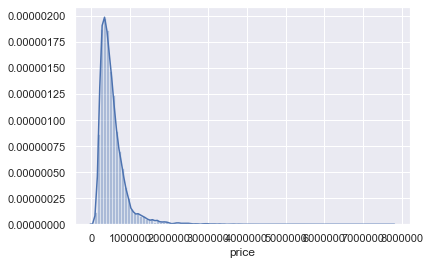

<Figure size 864x648 with 0 Axes>

In [5]:

sns.distplot(kc['price'], bins=100, hist_kws={'alpha':0.4})
fig = plt.figure(figsize=(12,9))


In [6]:
kc['price'].skew()

4.035378874466088

In [7]:
kc['price'].kurt()

34.680504355450644

In [ ]:
pd.plotting.scatter_matrix(kc,figsize  = [20, 20]);
plt.show()

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


In [ ]:
kc.zipcode.value_counts()

In [ ]:
zipcode = kc['zipcode'].value_counts()



fig, ax = plt.subplots(ncols=2, figsize=(14,5))
sns.countplot(x='zipcode', data=kc, ax=ax[0])
sns.boxplot(x='zipcode', y= 'price',
            data=kc, ax=ax[1])
plt.show()

In [ ]:
plt.figure(figsize = (12,8))
g = sns.FacetGrid(data=kc, hue='zipcode',size= 5, aspect=2)
g.map(plt.scatter, "sqft_living", "price")

plt.show()

In [ ]:
kc_zip = kc.groupby('zipcode')['price'].mean().reset_index()

kc_zip = kc_zip.sort_values(by=['price'])

plt.figure(figsize = (12,8))
plt.scatter(x=kc_zip['zipcode'], y=kc_zip['price'])


In [ ]:
import folium
import geopandas as gpd

In [ ]:
kc_zip_mean= kc.groupby('zipcode').aggregate(np.mean)
kc_zip_mean.head()
kc_zip_mean.drop(['lat', 'long'], axis=1, inplace=True)

kc_zip_mean.reset_index(inplace = True)
kc_zip_mean.head()



In [ ]:

map_kc = gpd.read_file('source/Zip_Codes/Zip_Codes.shp')

map_kc.head()


In [ ]:

map_kc['zipcode'] = map_kc['ZIPCODE']
map_kc.drop(['ZIP', 'ZIPCODE', 'OBJECTID'], axis=1, inplace=True)
map_kc.head()

In [ ]:
merged = pd.merge(map_kc, kc_zip_mean, on='zipcode')

merged.head()

In [ ]:
gdf=gpd.GeoDataFrame(merged, geometry=merged.geometry)

gdf.plot(column='price', k=5, colormap='OrRd', legend=True, figsize=(20,12))


In [ ]:
import fiona
import pysal as ps

from IPython.display import IFrame
gdf_test = gpd.read_file('source/Zip_Codes/Zip_Codes.shp')


gdf_test.head()

In [ ]:
%store -r hot_zip_codes
hot_zip_codes.reset_index(inplace=True)
hot_zip_codes['zipcode']=hot_zip_codes['zipcode'].astype(str)


In [ ]:
hot_zip_codes.drop(['lat', 'long'], axis=1, inplace=True)
hot_zip_codes

In [ ]:
appended_data = []

for zipcode in list(kc['zipcode'].unique()):
    if zipcode not in list(hot_zip_codes['zipcode']):
        appended_data.append({'zipcode':zipcode, 'rate_of_price_increase':0})
        
appended_df = pd.DataFrame(data=appended_data)

merged_df = pd.concat([hot_zip_codes, appended_df], axis=0)

merged_df['zipcode'].nunique()

In [ ]:
merged_2 = pd.merge(merged, merged_df, on='zipcode')

merged_2.info()

In [ ]:
gdf=gpd.GeoDataFrame(merged_2, geometry=merged_2.geometry)

gdf.plot(column='rate_of_price_increase', k=5, colormap='OrRd', legend=True, figsize=(20,12))


In [ ]:
merged_2

In [ ]:
merged_2

In [ ]:
hot_zipcodes_list = ['98034','98011','98028','98155','98133','98177',
                     '98125','98115','98103','98117','98107','98199']



kc_hot_zipcodes = kc[kc.zipcode.isin(hot_zipcodes_list)]



kc_hot_zipcodes



In [ ]:
zipcode = kc_hot_zipcodes['zipcode'].value_counts()



fig, ax = plt.subplots(ncols=2, figsize=(14,5))
sns.countplot(x='zipcode', data=kc_hot_zipcodes, ax=ax[0])
sns.boxplot(x='zipcode', y= 'price',
            data=kc_hot_zipcodes, ax=ax[1])
plt.show()

In [ ]:
plt.figure(figsize = (12,8))
g = sns.FacetGrid(data=kc_hot_zipcodes, hue='zipcode',size= 5, aspect=2)
g.map(plt.scatter, "sqft_living", "price")
plt.legend()
plt.show()

In [ ]:
corr = kc_hot_zipcodes.corr()
corr.style.background_gradient().set_precision(2)

In [ ]:
# kc_hot_zipcodes['bathrooms'] = kc_hot_zipcodes['bathrooms'].astype(str)
# kc_hot_zipcodes['bedrooms'] = kc_hot_zipcodes['bedrooms'].astype(str)
# kc_hot_zipcodes['condition'] = kc_hot_zipcodes['condition'].astype(str)
# kc_hot_zipcodes['floors'] = kc_hot_zipcodes['floors'].astype(str)
# kc_hot_zipcodes['grade'] = kc_hot_zipcodes['grade'].astype(str)
# kc_hot_zipcodes['sqft_basement'] = kc_hot_zipcodes['sqft_basement'].astype(float)
# kc_hot_zipcodes['view'] = kc_hot_zipcodes['view'].astype(str)
# kc_hot_zipcodes['waterfront'] = kc_hot_zipcodes['waterfront'].astype(str)
# kc_hot_zipcodes['yr_renovated'] = pd.to_datetime(kc_hot_zipcodes['yr_renovated'])

In [ ]:
kc_hot_zipcodes.info()

In [ ]:
# Whole Population 
kc_grade = kc_hot_zipcodes.sort_values(by=['grade'])
kc_grade_full = kc.sort_values(by =['grade'])

plt.figure(figsize = (12,8))
plt.subplots_adjust(hspace = 0.4, top = 1.5)

ax1 = plt.subplot(321)
ax1 = sns.countplot(x="grade", data=kc_grade_full,
                    ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.set_title("Grade Distribution for Whole Population", fontsize=15)

ax1.set_xlabel("grade")

# Add in Plot 2

ax2 = plt.subplot(322)
ax2 = sns.countplot(x="grade", data=kc_grade,
                    ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.set_title("Grade Distribution for Hot Zip Codes", fontsize=15)
ax2.set_xlabel("grade")

ax3 = plt.subplot(312)
ax3 = sns.stripplot(x="grade", y="price",
                    data=kc_grade, alpha=0.5,
                    jitter=True, hue="zipcode"
                   )
ax3.set_title("Grade/Price Distribution for Hot Zipcodes", fontsize=15)
ax3.set_xlabel("grade number")
ax3.set_ylabel("price")
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=90)
plt.legend().remove()
           
ax4 = plt.subplot(313)
ax4 = sns.stripplot(x="grade", y="price",
                    data=kc_grade_full, alpha=0.5,
                    jitter=True, hue="zipcode"
                   )
ax4.set_title("Grade/Price Distribution for Whole Population", fontsize=15)
ax4.set_xlabel("grade number")
ax4.set_ylabel("price")

ax4.set_xticklabels(ax4.get_xticklabels(),rotation=90)

plt.legend().remove()
plt.show()

In [ ]:
kc_hot_zipcodes.info()

In [ ]:
kc_not_hot_zipcodes = kc[~kc.zipcode.isin(hot_zipcodes_list)]

kc_not_hot_zipcodes

In [ ]:
scaler = StandardScaler()

In [ ]:
X = kc_hot_zipcodes[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                   'floors', 'condition', 'grade']]
y = kc_hot_zipcodes['price']

scaled_X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)



In [ ]:
scaled_X

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=0)

In [ ]:
model_kc = LinearRegression()  
model_kc.fit(X_train, y_train) #training the algorithms


In [ ]:
#To retrieve the intercept:
print(model_kc.intercept_)
#For retrieving the slope:
print(model_kc.coef_)

In [ ]:
y_pred = model_kc.predict(X_test)

In [ ]:
coeff_kc = pd.DataFrame(model_kc.coef_, scaled_X.columns, columns=['Coefficient'])  
coeff_kc

In [ ]:
model_kc.fit(X,y)

# Evaluating performance
r2 = model_kc.score(X,y)
r2 = r2.round(2)
print('R2 = {}'.format(r2))

# Understanding the LEARNED model
est_a = model_kc.intercept_
est_B = model_kc.coef_
print('constant: {}'.format(round(est_a,4)))
print('coeficients:  {} estimated'.format(est_B.round(4)))
coeff_kc

In [ ]:
model_kc_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

g = sns.lmplot(x="Predicted", y="Actual", data=model_kc_results)

In [ ]:
sns.distplot(y_pred)

In [ ]:
X_not_hot_zipcodes = kc_not_hot_zipcodes[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                   'floors', 'condition', 'grade']]
y_not_hot_zipcodes = kc_not_hot_zipcodes['price']

scaled_X_not_hot_zipcodes = pd.DataFrame(scaler.fit_transform(X_not_hot_zipcodes), columns=X_not_hot_zipcodes.columns)




In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(scaled_X_not_hot_zipcodes, y_not_hot_zipcodes,
                                                     test_size=0.2, random_state=0)

In [ ]:
model_kc_not_hot_zipcodes = LinearRegression()  
model_kc_not_hot_zipcodes.fit(X_train_2, y_train_2) #training the algorithms

In [ ]:
y_pred_not_hot_zipcodes = model_kc.predict(X_test_2)

In [ ]:
coeff_kc_not_hot_zipcodes = pd.DataFrame(model_kc_not_hot_zipcodes.coef_, scaled_X_not_hot_zipcodes.columns,
                                         columns=['Coefficient'])  
coeff_kc_not_hot_zipcodes

In [ ]:
model_kc.fit(X_not_hot_zipcodes,y_not_hot_zipcodes)

# Evaluating performance
r2 = model_kc.score(X_not_hot_zipcodes,y_not_hot_zipcodes)
r2 = r2.round(2)
print('R2 = {}'.format(r2))

# Understanding the LEARNED model
est_a = model_kc_not_hot_zipcodes.intercept_
est_B = model_kc_not_hot_zipcodes.coef_
print('constant: {}'.format(round(est_a,4)))
print('coeficients:  {} estimated'.format(est_B.round(4)))
coeff_kc_not_hot_zipcodes

In [ ]:
model_kc_not_hot_zipcdoes_results = pd.DataFrame({'Actual': y_test_2, 'Predicted': y_pred_not_hot_zipcodes})

g = sns.lmplot(x="Predicted", y="Actual", data=model_kc_not_hot_zipcdoes_results)

In [ ]:

sns.distplot(y_pred_not_hot_zipcodes)


In [ ]:
coeff_kc_not_hot_zipcodes - coeff_kc

In [ ]:
# gdf=gpd.GeoDataFrame(merged_2, geometry=merged_2.geometry)

# gdf.plot(column='rate_of_price_increase', k=5, colormap='OrRd', legend=True, figsize=(20,12))

kc_not_hot_zipcodes

In [ ]:

colors = sns.color_palette('Set2',2)

sns.set_style('dark')

sns.distplot(kc_hot_zipcodes['price'], bins=400,  color = colors[0])
sns.distplot(kc_not_hot_zipcodes['price'], bins=400,  color = colors[1])

plt.xlim(0, 2500000)

plt.show()


In [ ]:
merged_2['hot_zipcode'] = 0
print(len(hot_zipcodes_list))
merged_2.loc[merged_2.zipcode.isin(hot_zipcodes_list), 'hot_zipcode'] = 1

merged_2['hot_zipcode'].values

In [ ]:
gdf=gpd.GeoDataFrame(merged_2, geometry=merged_2.geometry)

gdf.plot(column='hot_zipcode', k=5, colormap='OrRd', legend=True, figsize=(20,12))



In [ ]:
merged_2['coords'] = merged_2['geometry'].apply(lambda x: x.representative_point().coords[:])
merged_2['coords'] = [coords[0] for coords in merged_2['coords']]

In [ ]:
merged_2.plot(column='hot_zipcode', k=5, cmap='OrRd_r', legend=False, figsize=(30,30))
for index, row in merged_2.iterrows():
    plt.annotate(s=row['zipcode'], xy=row['coords'],
                 horizontalalignment='center')
